# 주식 예측에 도전해보자.

- [이전 공부 자료](./Exploration6(1).ipynb)

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 <https://finance.yahoo.com/>에서 아래 그림을 따라하시면 다운로드 할 수 있습니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/E-16-5.max-800x600.png)

# Google 주식 가격을 예측해봅시다.

한번 구글의 주식 가격을 예측해봅시다!

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [4]:
dataset_path = os.path.dirname(os.path.abspath('__file__'))
google_path = dataset_path + r'/data/google.csv'

df = pd.read_csv(google_path, index_col = 'Date', parse_dates = True)

In [5]:
ts = df['Close']
ts.head(10)

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239193
2004-08-25    52.802086
2004-08-26    53.753517
2004-08-27    52.876804
2004-08-30    50.814533
2004-08-31    50.993862
2004-09-01    49.937820
Name: Close, dtype: float64

## 각종 전처리 수행

- 결측치 처리
- 로그 변환

In [6]:
# 결측치 처리
ts.isnull().sum()

0

결측치가 없네요! 그냥 진행하면 될 것 같습니다. 

로그로 변환해봅시다!

In [7]:
ts_log = np.log(ts)

## 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dickey-Fuller Test
- 시계열 분해 (Time Series Decomposition)
- Residual 안정성 확인

먼저 필요한 함수를 만들어줍시다.

In [19]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동 표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해봅시다.
    plt.figure(figsize = (10, 6))
    orig = plt.plot(timeseries, c='b', label='Original')
    mean = plt.plot(rolmean, c='r', label='Rolling Mean')
    std = plt.plot(rolstd, c='g', label='Rolling Std')
    plt.legend()
    plt.title("Rolling Mean & Standard Derivation")
    plt.show(block=False)

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    print("Results of Dickey Fuller Test")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Oservation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

이제 해봅시다!!

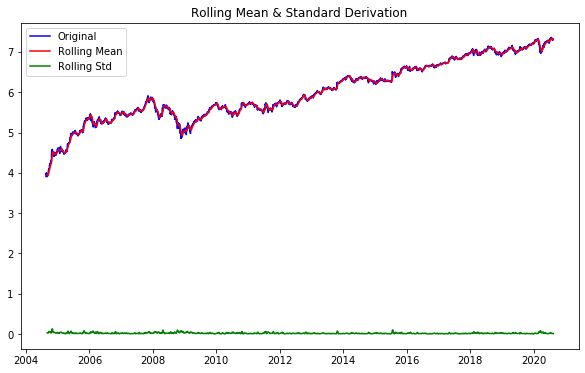

In [20]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [14]:
# 정량적 Augmented Dickey Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey Fuller Test
Test Statistic                 -2.296705
p-value                         0.173033
#Lags Used                     12.000000
Number of Oservation Used    4011.000000
Critical Value (1%)            -3.431981
Critical Value (5%)            -2.862261
Critical Value (10%)           -2.567154
dtype: float64


p-value가 꽤 크죠?!

In [15]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', period = 30)

In [16]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

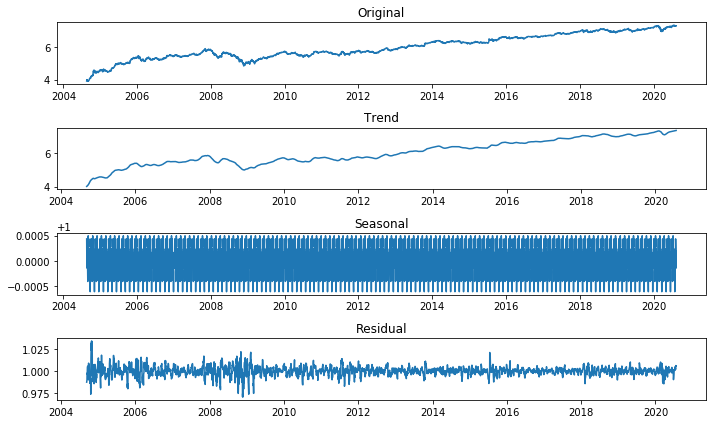

In [22]:
plt.figure(figsize = (10, 6))
plt.subplot(411)
plt.plot(ts_log)
plt.title("Original")

plt.subplot(412)
plt.plot(trend)
plt.title("Trend")

plt.subplot(413)
plt.plot(seasonal)
plt.title("Seasonal")

plt.subplot(414)
plt.plot(residual)
plt.title("Residual")

plt.tight_layout()

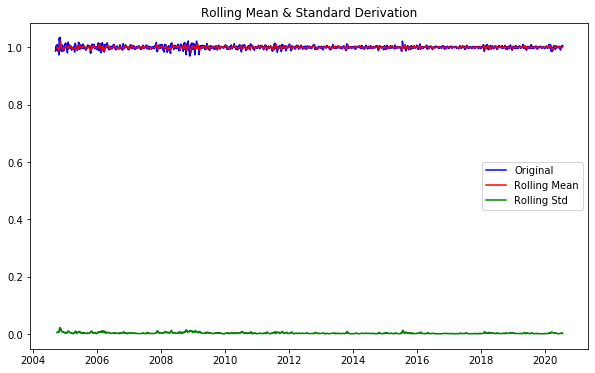

Results of Dickey Fuller Test
Test Statistic              -1.465120e+01
p-value                      3.498179e-27
#Lags Used                   3.000000e+01
Number of Oservation Used    3.963000e+03
Critical Value (1%)         -3.432001e+00
Critical Value (5%)         -2.862270e+00
Critical Value (10%)        -2.567158e+00
dtype: float64


In [24]:
# Residual 안정성 확인
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

## 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

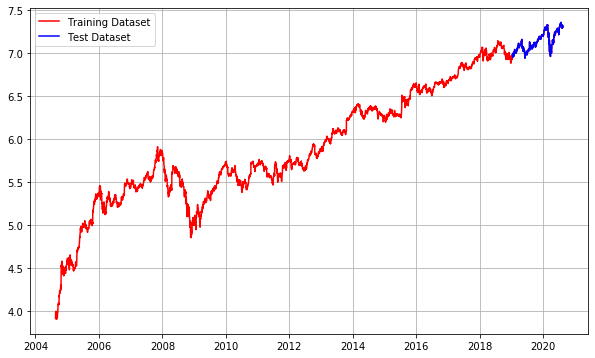

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label = 'Training Dataset')
plt.plot(test_data, c='b', label = 'Test Dataset')
plt.legend()
plt.show()

## 적정 ARIMA 모수 찾기

- ACF, PACF 그려서 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

<Figure size 720x432 with 0 Axes>

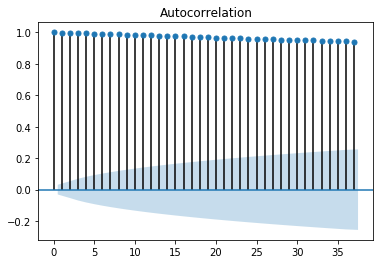

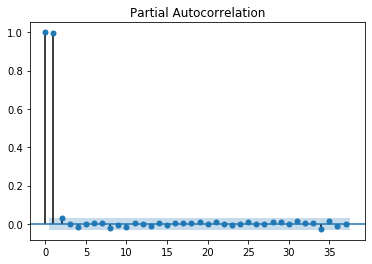

In [30]:
# ACF, PACF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

PACF를 선택하는 것이 더 좋아보인다!

- 차분 안정성 확인

Results of Dickey Fuller Test
Test Statistic              -1.760902e+01
p-value                      3.887867e-30
#Lags Used                   1.100000e+01
Number of Oservation Used    4.011000e+03
Critical Value (1%)         -3.431981e+00
Critical Value (5%)         -2.862261e+00
Critical Value (10%)        -2.567154e+00
dtype: float64


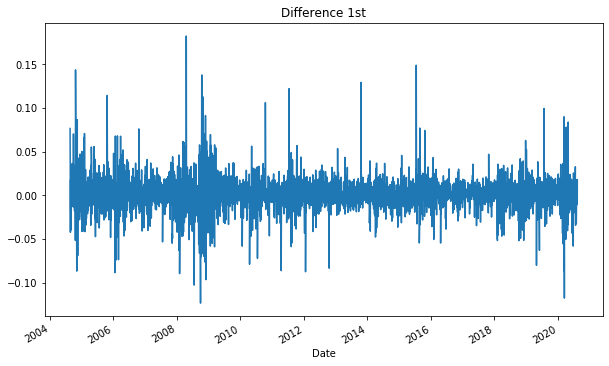

In [32]:
#차분 안정성 확인 -> d 구하기
plt.figure(figsize=(10, 6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
plt.show()

Results of Dickey Fuller Test
Test Statistic                -20.243438
p-value                         0.000000
#Lags Used                     31.000000
Number of Oservation Used    3990.000000
Critical Value (1%)            -3.431990
Critical Value (5%)            -2.862265
Critical Value (10%)           -2.567156
dtype: float64


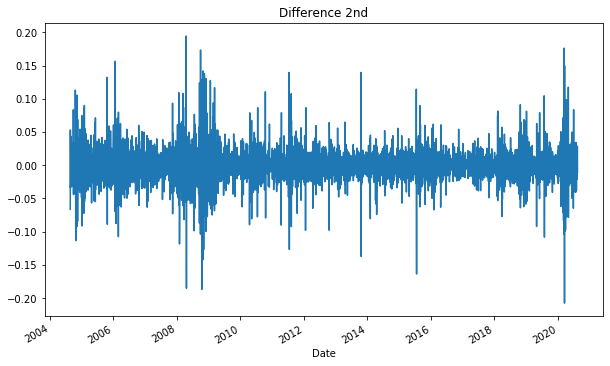

In [34]:
plt.figure(figsize=(10, 6))
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
plt.show()

## ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-2)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3620
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9211.049
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                         -18416.097
Time:                        16:57:56   BIC                         -18397.515
Sample:                             1   HQIC                        -18409.477
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.656      0.008       0.000       0.001
ar.L1.D.Close     0.0087      0.017      0.522      0.602      -0.024       0.041
                                    Root

/home/aiffel0039/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0039/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


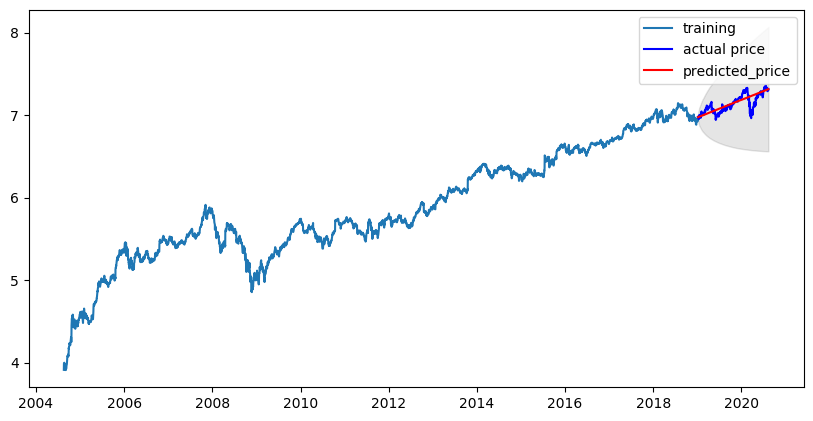

In [47]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10, 5), dpi = 100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c = 'r', label='predicted_price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
  # [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))  # [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mse) # [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)- np.exp(test_data))/ np.abs(np.exp(test_data))) # [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7697.22391996483
MAE:  62.38888049485952
RMSE:  87.73382426387687
MAPE: 5.04%
